In [1]:
import numpy as np
import pandas as pd
import pydicom as dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
# Working directory 
INPUT_FOLDER = 'Data/'

def find_dicom_folders(root_folder):
    dicom_folders = []
    for root, dirs, files in os.walk(root_folder):
        if any(file.endswith('.dcm') for file in files):
            dicom_folders.append(root)
    return dicom_folders

In [3]:
# Load
def load_scan(path):
    slices = [dicom.read_file(os.path.join(path, s)) for s in os.listdir(path) if s.endswith('.dcm')]
    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [4]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])

    image = image.astype(np.int16)

 
    image[image == -2000] = 0
    
 
    for slice_number in range(len(slices)):
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

# Find all DICOM folders
dicom_folders = find_dicom_folders(INPUT_FOLDER)

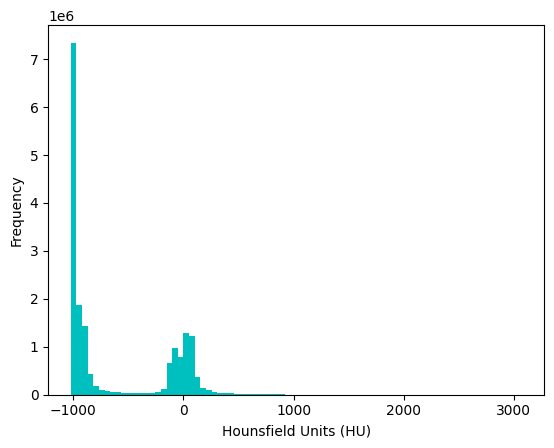

In [5]:
if dicom_folders:
    first_patient_folder = dicom_folders[0]
    first_patient = load_scan(first_patient_folder)
    first_patient_pixels = get_pixels_hu(first_patient)
    plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
    plt.xlabel("Hounsfield Units (HU)")
    plt.ylabel("Frequency")
    plt.show()
else:
    print("No DICOM folders found.")

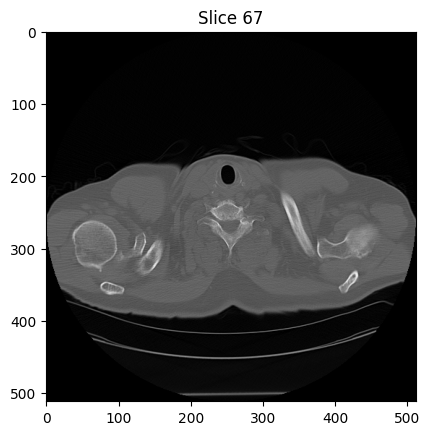

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def display_slice(image_array, index=None):
   
    num_slices = image_array.shape[0]
    
    if index is None:
     
        index = num_slices // 2
    elif index >= num_slices:
    
        index = num_slices - 1
    elif index < 0:
    
        index = 0
    

    plt.imshow(image_array[index], cmap=plt.cm.gray)
    plt.title(f"Slice {index}")
    plt.show()

# Example usage
slice_index = 67
display_slice(first_patient_pixels, slice_index)


In [7]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [8]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

C:\Users\Nithin Kodipyaka\AppData\Local\Temp\ipykernel_2772\3114917553.py:11: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')


Shape before resampling	 (68, 512, 512)
Shape after resampling	 (340, 425, 425)


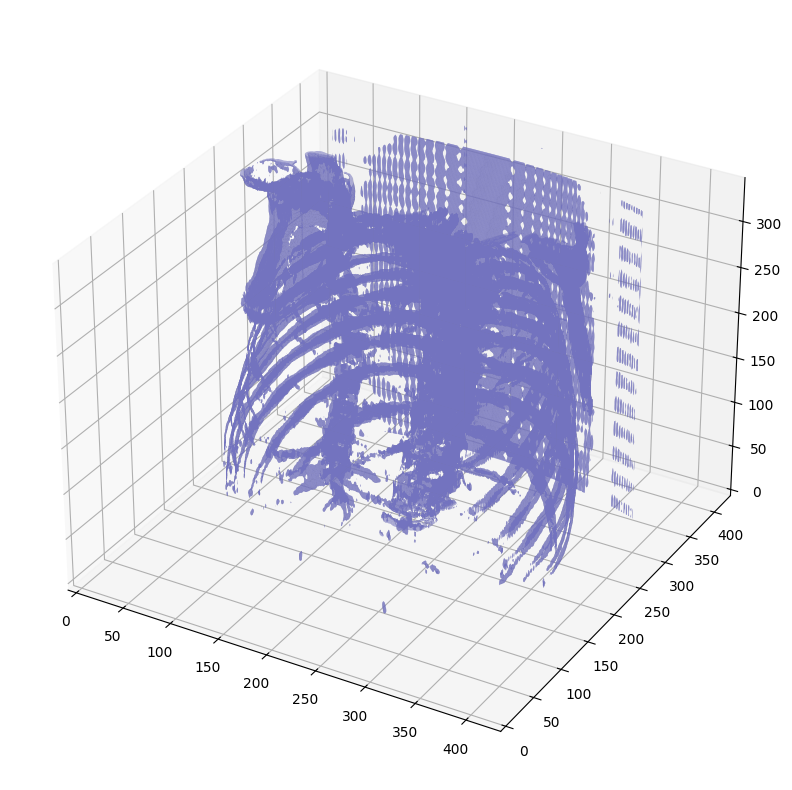

In [9]:
from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_3d(image, threshold=-300):

    p = image.transpose(2, 1, 0)
    

    verts, faces, _, _ = measure.marching_cubes(p, level=threshold)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Create a Poly3DCollection object from the vertices and faces
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)


    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

# Example usage
plot_3d(pix_resampled, 400)

In [10]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    


    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)

    background_label = labels[0,0,0]

    binary_image[background_label == labels] = 2

    if fill_lung_structures:
     
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None:
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1
    binary_image = 1-binary_image
    

    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None:
        binary_image[labels != l_max] = 0
 
    return binary_image

In [11]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

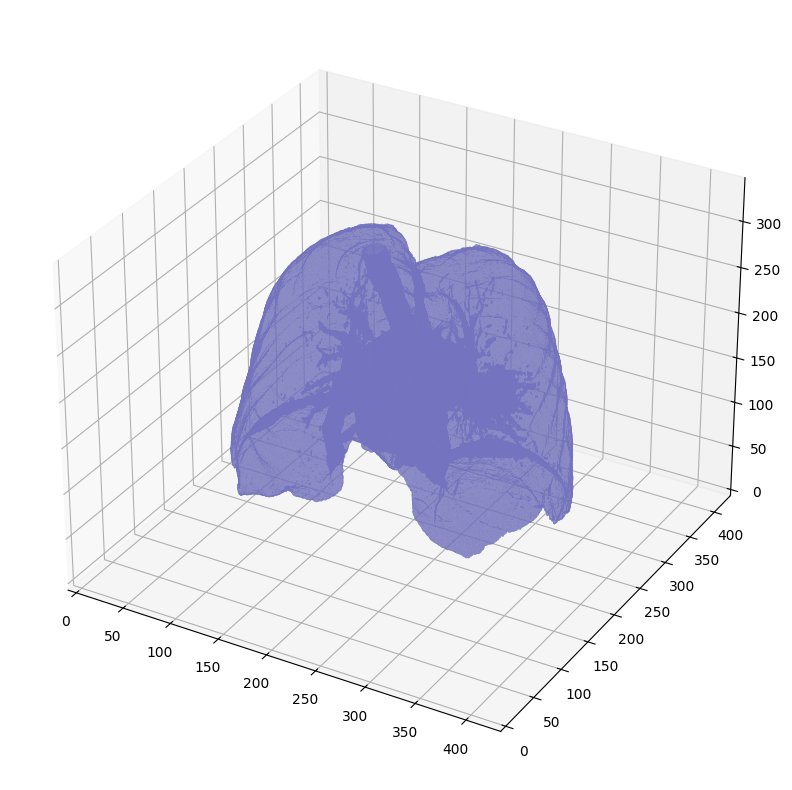

In [12]:
plot_3d(segmented_lungs, 0)


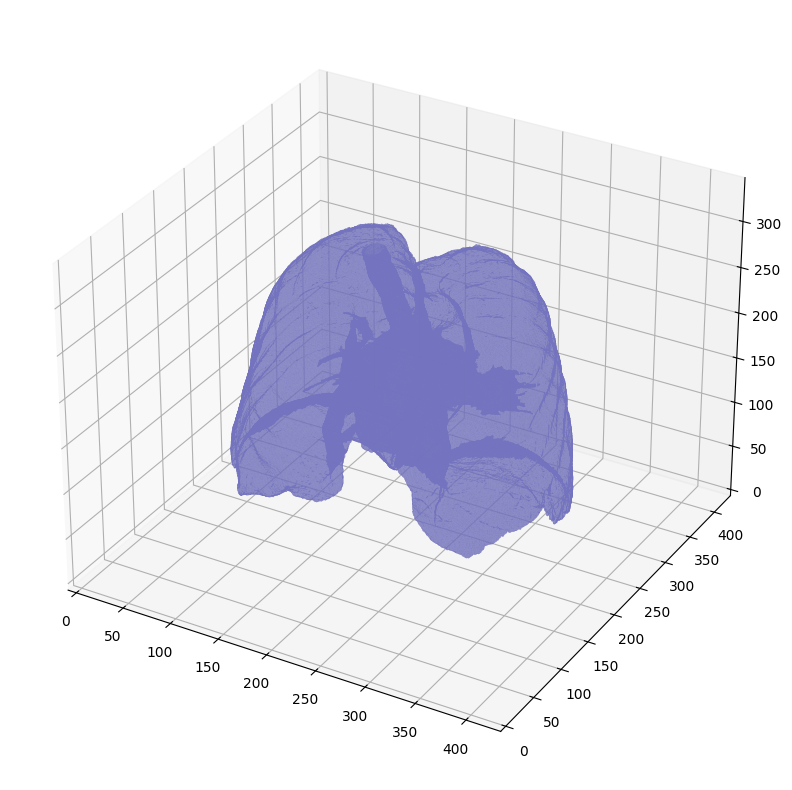

In [13]:
plot_3d(segmented_lungs_fill, 0)


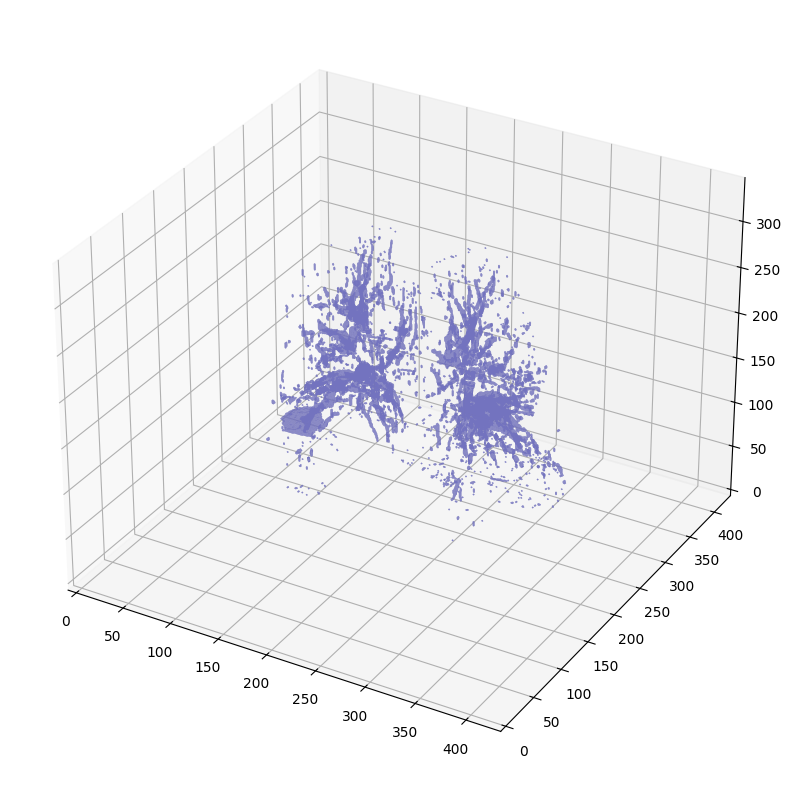

In [14]:
plot_3d(segmented_lungs_fill - segmented_lungs, 0)